In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
plt.style.use('ggplot')
import NSI # custom module, get it with: pip install git+https://github.com/yzerlaut/Network_State_Index

In [2]:
# loading data
data = NSI.IO.load_formatted_data('data/sample_data.npz')

Opening:  data/sample_data.npz


In [3]:
# analysis, see paper

# scripts contaning the two core functions:
from NSI.functions import preprocess_LFP, compute_Network_State_Index

# LFP processing
f0, w0, N_wavelets, smoothing = 72.2, 1.8, 5, 43e-3

preprocess_LFP(data,
               gain = 1.,
               Vext_key='Extra',
               freqs = np.linspace(f0/w0, f0*w0, N_wavelets),
               # percentile_for_p0=self.set_p0_percentile.value()/100.,                   
               new_dt = 5e-3,
               smoothing=smoothing)


# NSI
alpha, T_sliding_mean, Tstate = 2.85, 0.5, 0.2

compute_Network_State_Index(data,
                            Tstate=Tstate,
                            T_sliding_mean=T_sliding_mean,
                            alpha=alpha)

# now the "data" dictionary contains the "NSI" and "pLFP" variables

In [4]:
#####################################################################
##### A plot function that displays the output of the NSI analysis ##
#####################################################################

def show_NSI_analysis(data,
                      t0=0,
                      twidth=20.):
    """
    by default: LFP in mV and pLFP in uV (so factor )
    t0, twidth = 40, 20 # in seconds START and WIDTH of data displayed

    t0, twidth = 40, 20 # in seconds START and WIDTH of data displayed

    use: 
    fig, AX = show_NSI_analysis(data, t0=0., twidth=20.)
    """
    fig, AX = plt.subplots(3,1, figsize=(10,4))
    t = np.arange(len(data['Extra']))*data['dt']
    cond = (t>t0) & (t<t0+twidth)
    AX[0].plot(t[cond], data['Extra'][cond])
    t = np.arange(len(data['pLFP']))*data['new_dt']
    cond = (data['new_t']>t0) & (data['new_t']<t0+twidth)
    AX[1].plot(data['new_t'][cond], 1e3*data['pLFP'][cond], color='#8c564b')
    AX[2].plot(data['new_t'][cond], 1e3*data['NSI'][cond], color='k', lw=0.5)
    cond = (data['t_validated']>t0) & (data['t_validated']<t0+twidth)
    NSI = data['NSI'][data['NSI_validated']]
    AX[2].plot(data['t_validated'][cond & (NSI>0)], 1e3*NSI[cond & (NSI>0)], 'o', color='#bcbd22')
    AX[2].plot(data['t_validated'][cond & (NSI<=0)], 1e3*NSI[cond & (NSI<=0)], 'o', color='#9467bd')
    for ax, ylabel in zip(AX, ['LFP (mV)', 'pLFP (uV)', 'NSI (uV)']):
        ax.set_ylabel(ylabel)
        if ax==AX[-1]:
            ax.set_xlabel('time (s)')
        else:
            ax.set_xticklabels([])
    return fig, AX

## Network state variability at three time points in the recording:

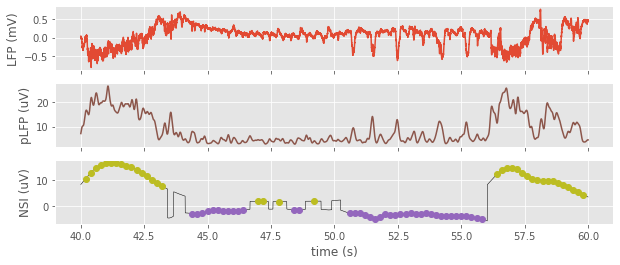

In [5]:
fig, AX = show_NSI_analysis(data, t0=40., twidth=20.)

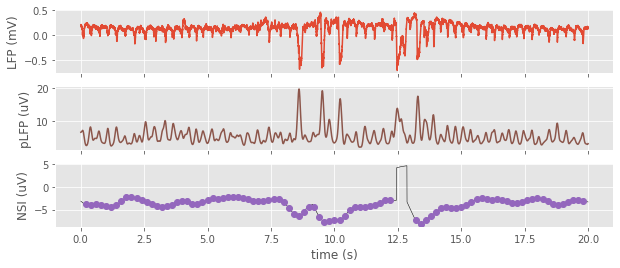

In [6]:
fig, AX = show_NSI_analysis(data, t0=0., twidth=20.)

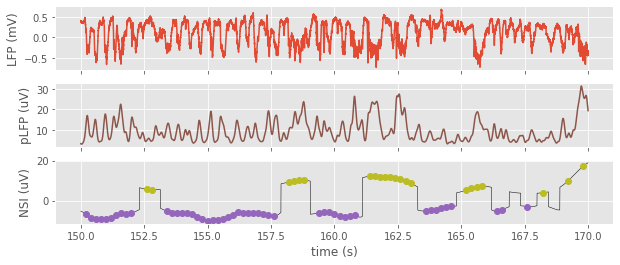

In [7]:
fig, AX = show_NSI_analysis(data, t0=150., twidth=20.)

## Histograms of NSI-defined network states along the whole recording

In [8]:
def compute_NSI_hist(data):
    """
    function to plot the histogram over the whole recording of the network state index

    use:
    fig, ax = compute_NSI_hist(data)
    """
    fig, ax = plt.subplots(1, figsize=(5,3))
    NSI = 1e3*data['NSI'][data['NSI_validated']]
    hist, be = np.histogram(NSI, bins = np.linspace(-1,1,30)*np.max(np.abs(NSI)), density=True)
    ax.bar(.5*(be[1:]+be[:-1]), hist, width=be[1]-be[0])
    xlim, ylim = ax.get_xlim(), ax.get_ylim()
    ax.fill_between([xlim[0],0], ylim[0], ylim[1], color='#9467bd', alpha=0.5)
    ax.fill_between([0, xlim[1]], ylim[0], ylim[1], color='#bcbd22', alpha=0.5)
    ax.annotate('rhythmic regimes  ', (0, ylim[1]), ha='right', va='bottom', color='#9467bd', fontsize=12)
    ax.annotate('  non-rhythmic regimes', (0, ylim[1]), ha='left', va='bottom', color='#bcbd22', fontsize=12)
    ax.set_xlim(xlim);ax.set_yticks([]);ax.set_ylim(ylim)
    ax.set_xlabel('NSI (uV)');ax.set_ylabel('occurence (norm.)')
    return fig, ax

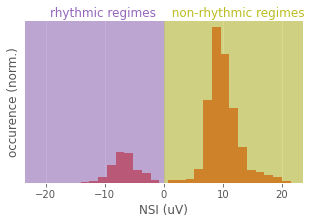

In [9]:
fig, ax = compute_NSI_hist(data)